In [9]:
#Importing Libraries
import numpy as np
import os
import pandas as pd
from numpy import array
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import re
import num2words
from tensorflow.keras import backend
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Lambda, Input, concatenate,BatchNormalization, Activation, Multiply
from keras.layers.embeddings import Embedding
from keras.layers import LSTM,Conv1D,MaxPooling1D, Bidirectional, GRU, RepeatVector, TimeDistributed
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from itertools import combinations
from keras_self_attention import SeqSelfAttention

%matplotlib inline

### Inter-rater agreement

In [10]:
local_path = r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inter_rater'
files_path = []
# r=root, d=directories, f = files
for r, d, f in os.walk(local_path):
    for file in f:
        if '.xlsx' in file:
            files_path.append(os.path.join(r, file))
            
n_files = len(files_path)
print(n_files)

2


In [13]:
dfs_test = []
for path in files_path:
    df = pd.read_excel(path)
    df = df[np.isfinite(df['Coder 1'])]
    df = df[np.isfinite(df['Coder 2 / Final'])]
    df['Coder 1'] = df['Coder 1'].astype(int)-1
    df['Coder 2 / Final'] = df['Coder 2 / Final'].astype(int)-1
    df['Utterance'] = df['Utterance'].apply(lambda row: re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), row))
    df['Utterance'] = df['Utterance'].apply(lambda row: row.replace('?',' ?'))
    dfs_test.append(df)
docs_size = pd.Series([df.shape[0] for df in dfs_test])
dfs_test[0].head()

,Utterance,Coder 1,Coder 2 / Final,The difference between the coders
0,Okei. No tässä tulee nyt se Maxwell-Bolzmannin...,0,0,0
1,"No nyt katotaan tää video, te ette varmaan oo ...",0,0,0
2,"Laita se vaikka tulee siitä niin, et me nähään...",0,0,0
3,[epäselvä] ...se siitä koneesta.,0,0,0
4,"Okei joo, sitten...",0,0,0


In [12]:
print(len(dfs[0].loc[dfs[0]['Coder 1'] == dfs[0]['Coder 2 / Final']])/len(dfs[0]))
print(len(dfs[1].loc[dfs[1]['Coder 1'] == dfs[1]['Coder 2 / Final']])/len(dfs[1]))

0.6973180076628352
0.6528497409326425


              precision    recall  f1-score   support

           0       0.78      0.68      0.73        47
           1       0.47      0.56      0.51        25
           2       0.82      0.81      0.81        78
           3       0.38      0.42      0.40        12
           4       0.68      0.69      0.68        99

    accuracy                           0.70       261
   macro avg       0.63      0.63      0.63       261
weighted avg       0.71      0.70      0.70       261



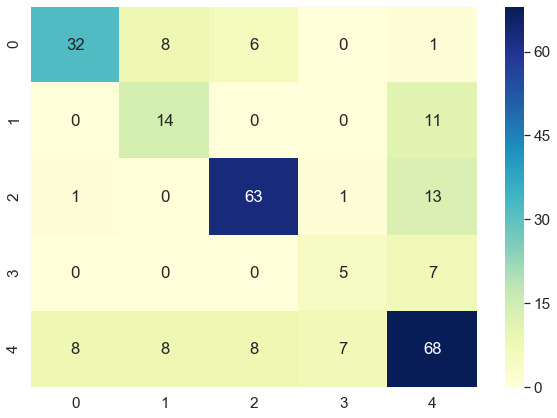

In [6]:
y_real_1 = dfs[0]['Coder 2 / Final'].astype(int)
y_pred_1 = dfs[0]['Coder 1'].astype(int)
results = confusion_matrix(y_real_1, y_pred_1)
df_cm_1 = pd.DataFrame(results, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm_1, annot=True, cmap="YlGnBu")
print(classification_report(y_real_1, y_pred_1))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76        58
           1       0.80      0.30      0.43        27
           2       0.68      0.84      0.75        49
           3       0.57      0.50      0.53         8
           4       0.55      0.45      0.49        51

    accuracy                           0.65       193
   macro avg       0.66      0.59      0.59       193
weighted avg       0.66      0.65      0.63       193



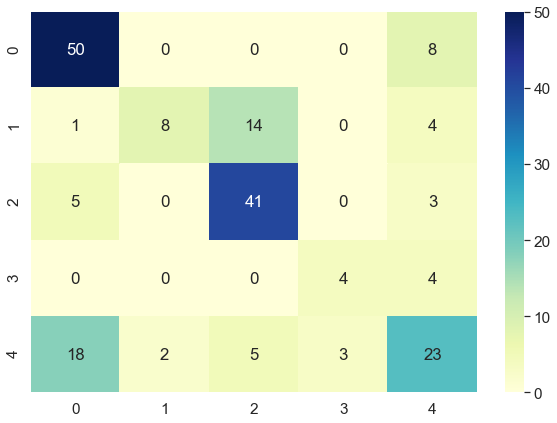

In [7]:
y_real_2 = dfs[1]['Coder 2 / Final'].astype(int)
y_pred_2 = dfs[1]['Coder 1'].astype(int)
results = confusion_matrix(y_real_2, y_pred_2)
df_cm_2 = pd.DataFrame(results, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm_2, annot=True, cmap="YlGnBu")
print(classification_report(y_real_2, y_pred_2))

              precision    recall  f1-score   support

           0       0.71      0.78      0.75       105
           1       0.55      0.42      0.48        52
           2       0.76      0.82      0.79       127
           3       0.45      0.45      0.45        20
           4       0.64      0.61      0.62       150

    accuracy                           0.68       454
   macro avg       0.62      0.62      0.62       454
weighted avg       0.67      0.68      0.67       454



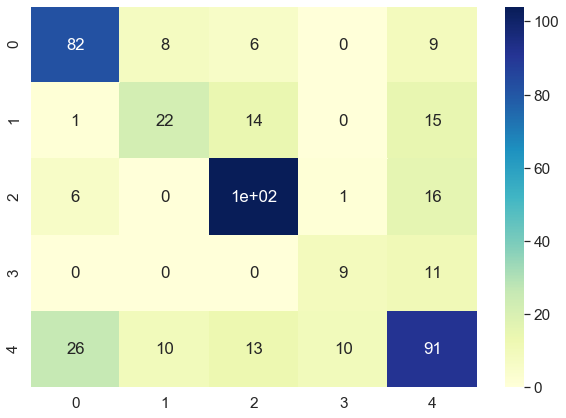

In [8]:
y_real = np.concatenate([y_real_1,y_real_2])
y_pred = np.concatenate([y_pred_1,y_pred_2])

df_cm = df_cm_1 + df_cm_2
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
print(classification_report(y_real, y_pred))

In [61]:
#Fitting the Tokenizer on the docs:
docs = [' '.join(list(df['Utterance'].astype(str))) for df in dfs]
t = Tokenizer(filters='¡!"\'#$%&()*+,./:;<=>@[\\]^_-`{|}~\t\n',num_words=2000)
t.fit_on_texts(docs)

In [19]:
#Add Previous and Next Utterance, Number of Words and Relative Position:
i = 1
max_length = 20
for df in dfs_test:
    print('Processing Document '+str(i))
    i+=1
    df['Relative Position'] = df.index/len(df)
    df['Number of Words'] = df.apply(lambda row: len(row['Utterance'].split()), axis = 1)
    df['Number of Words'] = df['Number of Words']/df['Number of Words'].max()
    df['Tokenized Utterance'] = df.apply(lambda row: t.texts_to_sequences([str(row['Utterance'])])[0], axis = 1)
    df['Previous Tokenized Utterance'] = df['Tokenized Utterance'].shift(1)
    df['Next Tokenized Utterance'] = df['Tokenized Utterance'].shift(-1)
    df = df.dropna()
print('Done!')

Processing Document 1
Processing Document 2
Done!


In [76]:
#Split Training and Test Set
documents_numbers = range(2)
couple = {0}

#Split Training and Test Set
training_dfs = [dfs[i] for i in (set(documents_numbers)-couple)]
all_data_train = pd.concat(training_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                            'Next Tokenized Utterance' ,'Relative Position',
                                                            'Number of Words','Coder 1','Coder 2 / Final']].dropna()

X_u_train = pad_sequences(all_data_train['Tokenized Utterance'],maxlen=max_length ,padding='post')
X_pu_train = pad_sequences(all_data_train['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
X_nu_train = pad_sequences(all_data_train['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

X_r_train = all_data_train['Relative Position']
X_n_train = all_data_train['Number of Words']

y_train_1 = keras.utils.to_categorical(all_data_train['Coder 1'], num_classes=5, dtype='float32')
y_train_2 = keras.utils.to_categorical(all_data_train['Coder 2 / Final'], num_classes=5, dtype='float32')
    
test_dfs = [dfs[i] for i in couple]

all_data_test = pd.concat(test_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                            'Next Tokenized Utterance' ,'Relative Position',
                                                            'Number of Words','Coder 1','Coder 2 / Final']].dropna()

X_u_test = pad_sequences(all_data_test['Tokenized Utterance'],maxlen=max_length ,padding='post')
X_pu_test = pad_sequences(all_data_test['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
X_nu_test = pad_sequences(all_data_test['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

X_r_test = all_data_test['Relative Position']
X_n_test = all_data_test['Number of Words']

y_test_1 = keras.utils.to_categorical(all_data_test['Coder 1'], num_classes=5, dtype='float32')
y_test_2 = keras.utils.to_categorical(all_data_test['Coder 2 / Final'], num_classes=5, dtype='float32')

In [24]:
#Create Embedding Matrix:
#Load the Embeddings
from gensim.models import KeyedVectors
path = r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/finnish_4B_parsebank_skgram.bin'
wv = KeyedVectors.load_word2vec_format(path,binary=True, encoding='UTF-8',limit=500000,unicode_errors='replace') 

#Build the Embedding Matrix
max_vocab = 10000
embedding_matrix = np.zeros((max_vocab, 200))
for word, i in t.word_index.items():
    try:
        embedding_vector = wv.get_vector(word)
        embedding_matrix[i] = embedding_vector
    except:
        pass 

/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [25]:
#Shared Encoder:
vocab_size = 10000
max_length = 20

from keras.activations import softmax

def softMaxAxis1(x):
    return softmax(x,axis=1)

#Utterance inputs
utterance_input = Input(shape=(max_length,), dtype='int32', name='utterance_input')
#Previous
previous_utterance_input = Input(shape=(max_length,), dtype='int32', name='p_utterance_input')
#Next
next_utterance_input = Input(shape=(max_length,), dtype='int32', name='n_utterance_input')

#Relative Position input
rel_position_input = Input(shape=(1,), dtype='float32', name='rel_position_input')
#Number of words input
n_words_input = Input(shape=(1,), dtype='float32', name='n_words_input')

#Embedding Layer
emb = Embedding(output_dim=200, input_dim=vocab_size, input_length=max_length, weights=[embedding_matrix],trainable=True)

embedded_previous = emb(previous_utterance_input)
embedded_utterance = emb(utterance_input)
embedded_next = emb(next_utterance_input)


x = concatenate([embedded_previous,embedded_utterance,embedded_next],axis = 1)

attention = TimeDistributed(Dense(1))
attention_parameters = attention(x)
attention_weigths = Activation(softMaxAxis1)(attention_parameters)

weighted_encoddings = Lambda(lambda x: x[0] * x[1])([x, attention_weigths])

#Decoder:

decoder = Lambda(lambda x: K.sum(x, axis=1))

#decoder = LSTM(10) -> Lento, malos resultados
#decoder = Flatten() -> Rápido, resultados moderados

x = decoder(weighted_encoddings)



x = concatenate([x,rel_position_input,n_words_input])

x = Dense(64, activation='relu')(x)

main_output = Dense(5, activation='softmax', name='main_output')(x)


model_7_full = Model(inputs=[previous_utterance_input,utterance_input,next_utterance_input, 
                             rel_position_input,n_words_input], outputs=[main_output])
model_7_full.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_7_full.name = 'pte_simple_at'

model_7_full.save_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'.h5')

model_7_full.save(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/models/attention/'+str(model_7_full.name)+'.h5')

### Model 1 - Coder 1

In [93]:
#Load Initial Random Weights:
model_7_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'.h5')

#Checkpoint
checkpoint_7_full = ModelCheckpoint('/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'_testing1.h5', 
                             verbose=1, monitor='val_acc',save_best_only=True, mode='auto')

EA = EarlyStopping(monitor='val_loss', patience=7)

#Fit Model:
history = model_7_full.fit({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train},
                            {'main_output': y_train_1}, validation_data= 
                           ({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test},
                            {'main_output': y_test_1}),
                           epochs=40, batch_size=64,
                            shuffle=True, callbacks = [checkpoint_7_full,EA])

Train on 191 samples, validate on 259 samples
Epoch 1/40
191/191 [==============================] - 1s 3ms/step - loss: 1.6022 - acc: 0.1466 - val_loss: 1.6054 - val_acc: 0.1506

Epoch 00001: val_acc improved from -inf to 0.15058, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pte_simple_at_testing1.h5
Epoch 2/40
191/191 [==============================] - 1s 3ms/step - loss: 1.5720 - acc: 0.2618 - val_loss: 1.5925 - val_acc: 0.2896

Epoch 00002: val_acc improved from 0.15058 to 0.28958, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pte_simple_at_testing1.h5
Epoch 3/40
191/191 [==============================] - 0s 2ms/step - loss: 1.5288 - acc: 0.4660 - val_loss: 1.5811 - val_acc: 0.3282

Epoch 00003: val_acc improved from 0.28958 to 0.32819, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pte_simple_at_testing1.h5
Epoch 4/40
191/191 [==============================] - 0s 2ms/step - loss: 1.4829 - acc: 0.5183 -

              precision    recall  f1-score   support

           0       0.23      0.78      0.35        40
           1       0.00      0.00      0.00        30
           2       0.57      0.70      0.63        77
           3       0.00      0.00      0.00        13
           4       0.38      0.11      0.17        99

    accuracy                           0.37       259
   macro avg       0.24      0.32      0.23       259
weighted avg       0.35      0.37      0.31       259



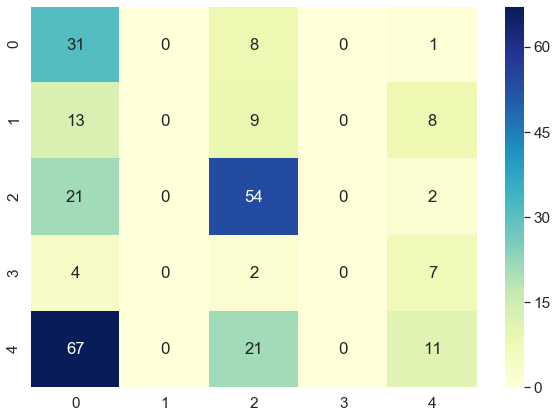

In [99]:
model_7_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'_testing1.h5')
y_real = y_test_1.argmax(axis=-1)
y_pred = model_7_full.predict({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test}).argmax(axis=-1)
results = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(results, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
print(classification_report(y_real, y_pred))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

### Model 1 - Coder 2

              precision    recall  f1-score   support

           0       0.26      0.78      0.40        46
           1       0.00      0.00      0.00        25
           2       0.56      0.68      0.62        78
           3       0.00      0.00      0.00        12
           4       0.52      0.15      0.24        98

    accuracy                           0.40       259
   macro avg       0.27      0.32      0.25       259
weighted avg       0.41      0.40      0.35       259



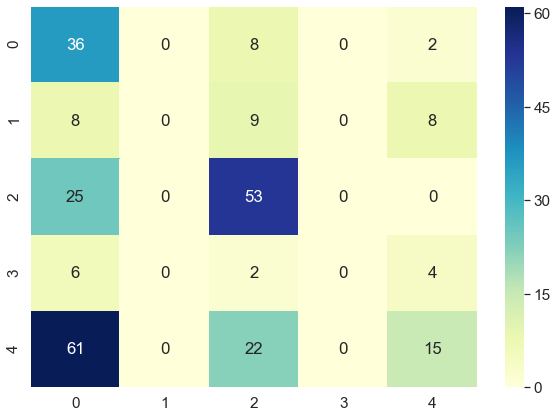

In [102]:
model_7_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'_testing1.h5')
y_real = y_test_2.argmax(axis=-1)
y_pred = model_7_full.predict({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test}).argmax(axis=-1)
results = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(results, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
print(classification_report(y_real, y_pred))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

### Model 2 - Coder 2

In [97]:
#Load Initial Random Weights:
model_7_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'.h5')

#Checkpoint
checkpoint_7_full = ModelCheckpoint('/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'_testing2.h5', 
                             verbose=1, monitor='val_acc',save_best_only=True, mode='auto')

EA = EarlyStopping(monitor='val_loss', patience=7)

#Fit Model:
history = model_7_full.fit({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train},
                            {'main_output': y_train_2}, validation_data= 
                           ({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test},
                            {'main_output': y_test_2}),
                           epochs=40, batch_size=64,
                            shuffle=True, callbacks = [checkpoint_7_full,EA])

Train on 191 samples, validate on 259 samples
Epoch 1/40
191/191 [==============================] - 0s 2ms/step - loss: 1.6009 - acc: 0.1099 - val_loss: 1.6059 - val_acc: 0.1197

Epoch 00001: val_acc improved from -inf to 0.11969, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pte_simple_at_testing2.h5
Epoch 2/40
191/191 [==============================] - 1s 3ms/step - loss: 1.5799 - acc: 0.1990 - val_loss: 1.5876 - val_acc: 0.1931

Epoch 00002: val_acc improved from 0.11969 to 0.19305, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pte_simple_at_testing2.h5
Epoch 3/40
191/191 [==============================] - 0s 2ms/step - loss: 1.5523 - acc: 0.3037 - val_loss: 1.5670 - val_acc: 0.3282

Epoch 00003: val_acc improved from 0.19305 to 0.32819, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pte_simple_at_testing2.h5
Epoch 4/40
191/191 [==============================] - 0s 2ms/step - loss: 1.5244 - acc: 0.4188 -

              precision    recall  f1-score   support

           0       0.33      0.67      0.44        46
           1       0.78      0.28      0.41        25
           2       0.69      0.72      0.70        78
           3       0.00      0.00      0.00        12
           4       0.67      0.51      0.58        98

    accuracy                           0.56       259
   macro avg       0.49      0.44      0.43       259
weighted avg       0.59      0.56      0.55       259



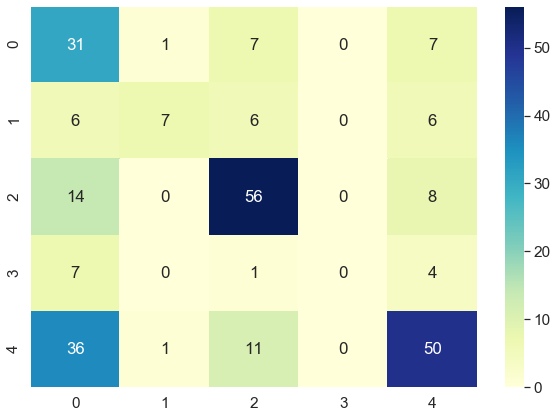

In [100]:
model_7_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'_testing2.h5')
y_real = y_test_2.argmax(axis=-1)
y_pred = model_7_full.predict({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test}).argmax(axis=-1)
results = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(results, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
print(classification_report(y_real, y_pred))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

### Model 2 - Coder 1

              precision    recall  f1-score   support

           0       0.28      0.65      0.39        40
           1       0.56      0.17      0.26        30
           2       0.65      0.69      0.67        77
           3       0.00      0.00      0.00        13
           4       0.57      0.43      0.49        99

    accuracy                           0.49       259
   macro avg       0.41      0.39      0.36       259
weighted avg       0.52      0.49      0.48       259



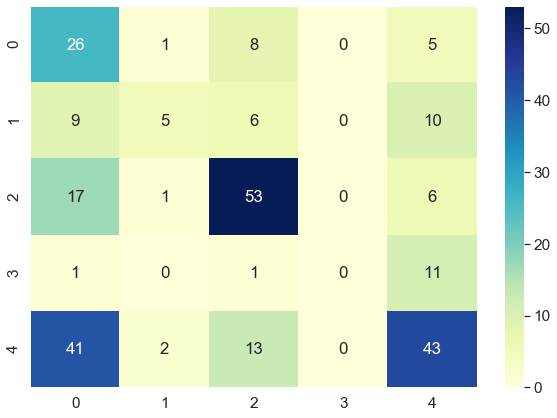

In [101]:
model_7_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'_testing2.h5')
y_real = y_test_1.argmax(axis=-1)
y_pred = model_7_full.predict({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test}).argmax(axis=-1)
results = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(results, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
print(classification_report(y_real, y_pred))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

In [14]:
local_path = r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons'
files_path = []
# r=root, d=directories, f = files
for r, d, f in os.walk(local_path):
    for file in f:
        if '.xlsx' in file:
            files_path.append(os.path.join(r, file))
            print(os.path.join(r, file))
            
n_files = len(files_path)
print('Number of Files: '+str(n_files))

/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons/Group2_2017_Scaffold1.xlsx
/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons/Group3C_2017_Scaffold2.xlsx
/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons/Group4_2017_Scaffold1.xlsx
/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons/Group9_2016_No_scaffold.xlsx
/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons/Group4B_2017_Scaffold2.xlsx
/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons/Group3_2016_No_scaffold.xlsx
/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons/Group5_2017_Scaffold2.xlsx
/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons/Group5_2016_No_scaffold.xlsx
/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons/Group6A_2017_Scaffold1.xlsx
/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons/Group12_2016_No_scaffold.xlsx
/Users/pablouribepizarro/Desktop/CIAE/CIBL/Raw/inquiry_lessons/Group3_2017_Scaffold2.xls

In [15]:
dfs = []
for path in files_path:
    df = pd.read_excel(path)
    df = df[np.isfinite(df['Phase'])]
    df['Phase'] = df['Phase'].astype(int)-1
    df['Utterance'] = df['Utterance'].apply(lambda row: re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), row))
    df['Utterance'] = df['Utterance'].apply(lambda row: row.replace('?',' ?'))
    dfs.append(df)
docs_size = pd.Series([df.shape[0] for df in dfs])
dfs[0].head()

,StudentID,Student,time_start,time_end,Phase,Phase_start,Phase_end,Utterance
0,O2,NaN,NaN,NaN,0,1.0,NaN,Satunnaiskävely.
1,O1,NaN,NaN,NaN,0,NaN,NaN,[lukee tehtävänantoa]
2,O1,NaN,NaN,NaN,0,NaN,1.0,Voi voi. [käynnistää videon]
3,O1,NaN,NaN,NaN,0,1.0,NaN,"Missä se vaeltaa siellä ? Onks se, ei. Ei, se ..."
4,O2,NaN,NaN,NaN,0,NaN,NaN,[epäselvä]


In [16]:
#Fitting the Tokenizer on the docs:
docs = [' '.join(list(df['Utterance'].astype(str))) for df in dfs]
t = Tokenizer(filters='¡!"\'#$%&()*+,./:;<=>@[\\]^_-`{|}~\t\n',num_words=2000)
t.fit_on_texts(docs)

In [17]:
#Add Previous and Next Utterance, Number of Words and Relative Position:
i = 1
max_length = 20
for df in dfs:
    print('Processing Document '+str(i))
    i+=1
    df['Relative Position'] = df.index/len(df)
    df['Number of Words'] = df.apply(lambda row: len(row['Utterance'].split()), axis = 1)
    df['Number of Words'] = df['Number of Words']/df['Number of Words'].max()
    df['Tokenized Utterance'] = df.apply(lambda row: t.texts_to_sequences([str(row['Utterance'])])[0], axis = 1)
    df['Previous Tokenized Utterance'] = df['Tokenized Utterance'].shift(1)
    df['Next Tokenized Utterance'] = df['Tokenized Utterance'].shift(-1)
    df = df.dropna()
print('Done!')

Processing Document 1
Processing Document 2
Processing Document 3
Processing Document 4
Processing Document 5
Processing Document 6
Processing Document 7
Processing Document 8
Processing Document 9
Processing Document 10
Processing Document 11
Done!


In [22]:
#Split Training and Test Set
documents_numbers = range(11)
couple = {1,8}

#Split Training and Test Set
training_dfs = [dfs[i] for i in (set(documents_numbers)-couple)]
all_data_train = pd.concat(training_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                            'Next Tokenized Utterance' ,'Relative Position',
                                                            'Number of Words','Phase']].dropna()

X_u_train = pad_sequences(all_data_train['Tokenized Utterance'],maxlen=max_length ,padding='post')
X_pu_train = pad_sequences(all_data_train['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
X_nu_train = pad_sequences(all_data_train['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

X_r_train = all_data_train['Relative Position']
X_n_train = all_data_train['Number of Words']

y_train = keras.utils.to_categorical(all_data_train['Phase'], num_classes=5, dtype='float32')
    

all_data_test = pd.concat(dfs_test).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                            'Next Tokenized Utterance' ,'Relative Position',
                                                            'Number of Words','Coder 1','Coder 2 / Final']].dropna()

all_data_test = all_data_test.loc[all_data_test['Coder 1'] == all_data_test['Coder 2 / Final']]

X_u_test = pad_sequences(all_data_test['Tokenized Utterance'],maxlen=max_length ,padding='post')
X_pu_test = pad_sequences(all_data_test['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
X_nu_test = pad_sequences(all_data_test['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

X_r_test = all_data_test['Relative Position']
X_n_test = all_data_test['Number of Words']

y_test = keras.utils.to_categorical(all_data_test['Coder 1'], num_classes=5, dtype='float32')

/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [26]:
#Load Initial Random Weights:
model_7_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'.h5')

#Checkpoint
checkpoint_7_full = ModelCheckpoint('/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'_testing.h5', 
                             verbose=1, monitor='val_acc',save_best_only=True, mode='auto')

EA = EarlyStopping(monitor='val_loss', patience=7)

#Fit Model:
history = model_7_full.fit({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train},
                            {'main_output': y_train}, validation_data= 
                           ({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test},
                            {'main_output': y_test}),
                           epochs=40, batch_size=64,
                            shuffle=True, callbacks = [checkpoint_7_full,EA])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1507 samples, validate on 305 samples
Epoch 1/40
1507/1507 [==============================] - 5s 3ms/step - loss: 1.4827 - acc: 0.3344 - val_loss: 1.3498 - val_acc: 0.3934

Epoch 00001: val_acc improved from -inf to 0.39344, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pte_simple_at_testing.h5
Epoch 2/40
1507/1507 [==============================] - 3s 2ms/step - loss: 1.2859 - acc: 0.4519 - val_loss: 1.1401 - val_acc: 0.5279

Epoch 00002: val_acc improved from 0.39344 to 0.52787, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pte_simple_at_testing.h5
Epoch 3/40
1507/1507 [==============================] - 3s 2ms/step - loss: 1.1825 - acc: 0.5727 - val_loss: 1.1075 - val_acc: 0.5836

Epoch 00003: val_acc improved from 0.52787 to 0.58361, saving model to /Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/pte_simple_at_testing.h

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        81
           1       0.60      0.41      0.49        22
           2       0.83      0.70      0.76       104
           3       0.00      0.00      0.00         9
           4       0.55      0.78      0.64        89

    accuracy                           0.67       305
   macro avg       0.54      0.51      0.52       305
weighted avg       0.68      0.67      0.67       305



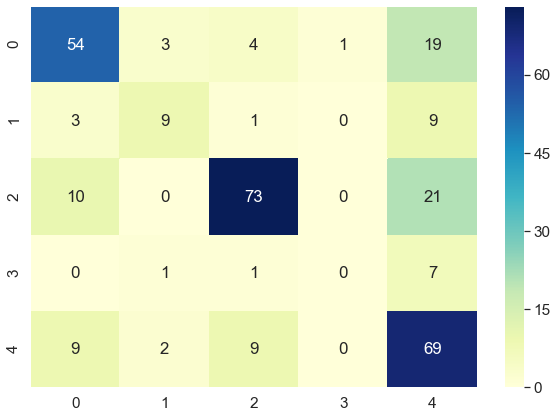

In [27]:
model_7_full.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model_7_full.name)+'_testing.h5')
y_real = y_test.argmax(axis=-1)
y_pred = model_7_full.predict({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test}).argmax(axis=-1)
results = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(results, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
print(classification_report(y_real, y_pred))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")